In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential, load_model

In [3]:
from datetime import date
from dateutil.relativedelta import relativedelta
start = date.today() - relativedelta(years=10)
end = date.today()

df = pdr.DataReader('AAPL', 'yahoo', start, end)
df = df.reset_index()
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-05-24,20.589287,20.043928,20.566786,20.190001,496230000.0,17.262814
1,2012-05-25,20.208929,19.945356,20.163929,20.081785,328507200.0,17.170286
2,2012-05-29,20.500000,20.189644,20.389286,20.438213,380508800.0,17.475037
3,2012-05-30,20.713928,20.234285,20.328571,20.684643,529429600.0,17.685741
4,2012-05-31,20.767857,20.409286,20.740713,20.633215,491674400.0,17.641771


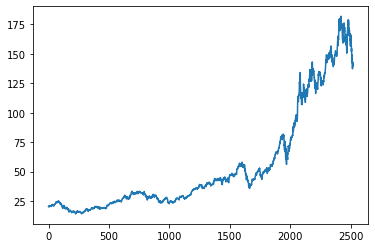

In [4]:
plt.plot(df.Close)

In [5]:
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))

data_training_array = scaler.fit_transform(data_training)

In [7]:
x_train =[]
y_train =[]

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [8]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences =True,
              input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences =True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences =True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

In [11]:
import keras_metrics as km
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])
model.fit(x_train,y_train, epochs = 50)

Epoch 1/50
52/52 [==============================] - 16s 223ms/step - loss: 0.0428 - accuracy: 6.0168e-04
Epoch 2/50
52/52 [==============================] - 11s 219ms/step - loss: 0.0103 - accuracy: 0.0012
Epoch 3/50
52/52 [==============================] - 11s 208ms/step - loss: 0.0091 - accuracy: 0.0012
Epoch 4/50
52/52 [==============================] - 11s 214ms/step - loss: 0.0068 - accuracy: 0.0012
Epoch 5/50
52/52 [==============================] - 11s 210ms/step - loss: 0.0068 - accuracy: 0.0012
Epoch 6/50
52/52 [==============================] - 12s 230ms/step - loss: 0.0063 - accuracy: 0.0012
Epoch 7/50
52/52 [==============================] - 12s 228ms/step - loss: 0.0059 - accuracy: 0.0012
Epoch 8/50
52/52 [==============================] - 14s 261ms/step - loss: 0.0060 - accuracy: 0.0012
Epoch 9/50
52/52 [==============================] - 12s 232ms/step - loss: 0.0057 - accuracy: 0.0012
Epoch 10/50
52/52 [==============================] - 11s 218ms/step - loss: 0.0053 - ac

In [12]:
filename = "lstm_model"
model.save(filename)

INFO:tensorflow:Assets written to: lstm_model\assets


In [13]:
past_100_days = data_training.tail(100)
final_df = past_100_days.append(data_testing, ignore_index=True)
input_data = scaler.fit_transform(final_df)

In [14]:
x_test =[]
y_test =[]

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i, 0])

x_test = np.array(x_test)
y_test = np.array(y_test)

In [15]:
y_prediction = model.predict(x_test)

24/24 [==============================] - 4s 111ms/step


In [25]:
scale = scaler.scale_
scale_factor = 1/scale[0]
y_prediction = y_prediction*scale_factor
y_test = y_test*scale_factor

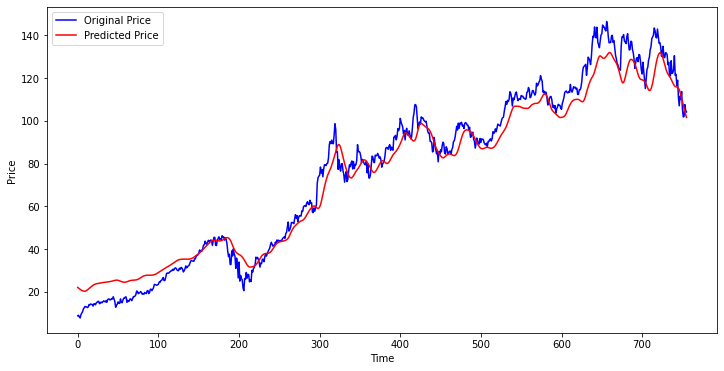

In [26]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = 'Original Price')
plt.plot(y_prediction, 'r', label = 'Predicted Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(y_test, y_prediction)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_test, y_prediction)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_test, y_prediction))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_test - y_prediction )/np.abs(y_prediction))
print('MAPE: '+str(mape))

MSE: 52.12491403871332
MAE: 5.790802307229827
RMSE: 7.2197585859025315
MAPE: 0.8367147141209048


In [50]:
mape = np.mean(np.abs( y_prediction-y_test )/np.abs(y_test ))
print('MAPE: '+str(mape))

MAPE: 1.0334430152623546


In [49]:
y_prediction.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

,Close
0,20.190001
1,20.081785
2,20.438213
3,20.684643
4,20.633215
